Imports & setup

In [4]:
import os
import json
import pandas as pd
import numpy as np
import torch
from transformers import (
T5TokenizerFast,
T5ForConditionalGeneration,
Trainer,
TrainingArguments,
DataCollatorForSeq2Seq
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
import sacrebleu
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


Mount drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load dataset

In [8]:
DATA_PATH = '/content/drive/MyDrive/C-Assist_Dataset.csv'
assert os.path.exists(DATA_PATH), (
f"Dataset not found at {DATA_PATH}. Please upload your dataset in the working dir"
)
raw_df = pd.read_csv(DATA_PATH)
print('Raw shape:', raw_df.shape)
print('Columns:', raw_df.columns.tolist())

Raw shape: (336, 2)
Columns: ['Question', 'Answer']


Basic EDA

In [14]:
# Identify likely question/answer columns (common names)
possible_q_cols = [c for c in raw_df.columns if 'question' in c.lower() or 'q' == c.lower()]
possible_a_cols = [c for c in raw_df.columns if 'answer' in c.lower() or 'a' == c.lower()]
print('Possible question columns:', possible_q_cols)
print('Possible answer columns:', possible_a_cols)
# If columns are ambiguous, choose the first two columns as fallback
if len(possible_q_cols) == 0 or len(possible_a_cols) == 0:
    q_col, a_col = raw_df.columns[0], raw_df.columns[1]
else:
    q_col, a_col = possible_q_cols[0], possible_a_cols[0]
print('Using question column:', q_col)
print('Using answer column:', a_col)
# Show missing values and lengths
print('\nMissing values:')
print(raw_df[[q_col, a_col]].isnull().sum())
raw_df['question_text'] = raw_df[q_col].astype(str)
raw_df['answer_text'] = raw_df[a_col].astype(str)
raw_df['q_len'] = raw_df['question_text'].apply(len)
raw_df['a_len'] = raw_df['answer_text'].apply(len)

Possible question columns: ['Question', 'question_text']
Possible answer columns: ['Answer', 'answer_text']
Using question column: Question
Using answer column: Answer

Missing values:
Question    0
Answer      0
dtype: int64


Quick histograms

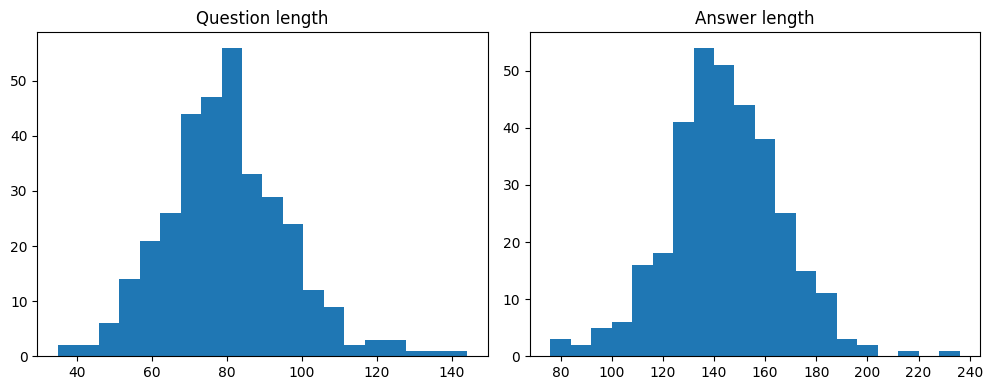

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(raw_df['q_len'], bins=20)
plt.title('Question length')
plt.subplot(1, 2, 2)
plt.hist(raw_df['a_len'], bins=20)
plt.title('Answer length')
plt.tight_layout()
plt.show()

Preprocessing functions

In [18]:
import re
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text)
    # Normalize whitespace
    text = ' '.join(text.split())
    # Replace fancy quotes
    text = text.replace('\u2019', "'").replace('\u201c', '"').replace('\u201d', '"')
    # Remove control chars
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
# Apply cleaning
raw_df['question_text'] = raw_df['question_text'].apply(clean_text)
raw_df['answer_text'] = raw_df['answer_text'].apply(clean_text)
# Drop empty rows
df = raw_df[(raw_df['question_text'] != '') & (raw_df['answer_text'] != '')].copy()
print('After cleaning:', len(df))
# Rename for consistency
df = df.rename(columns={'question_text': 'question', 'answer_text': 'answer'})

After cleaning: 336


Train / Validation / Test split

In [19]:
train_df, temp_df = train_test_split(df[['question','answer']], test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)
print('Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))
# Convert to HuggingFace Dataset for easier mapping
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

Train: 268 Val: 34 Test: 34


Model selection and tokenizer

In [21]:
# Choose model: t5-small
MODEL_NAME = 't5-small'
tokenizer = T5TokenizerFast.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)
print('Loaded model:', MODEL_NAME)
print('Model params:', model.num_parameters())

Loaded model: t5-small
Model params: 60506624


Preprocessing for model (tokenization)

In [48]:
MAX_INPUT_LENGTH = 128
MAX_TARGET_LENGTH = 128
prefix = 'answer question: '
def preprocess_function(examples):
    inputs = [prefix + q for q in examples['question']]
    targets = examples['answer']
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length'
    )
    labels = tokenizer(
        targets,
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding='max_length'
    )['input_ids']
    # Replace padding token id with -100 for T5 loss
    labels = [[(token if token != tokenizer.pad_token_id else -100) for token in label] for label in labels]
    model_inputs['labels'] = labels
    return model_inputs
train_tokenized = train_ds.map(
    preprocess_function, batched=True, remove_columns=train_ds.column_names
)
val_tokenized = val_ds.map(
    preprocess_function, batched=True, remove_columns=val_ds.column_names
)
test_tokenized = test_ds.map(
    preprocess_function, batched=True, remove_columns=test_ds.column_names
)
print('Tokenization done')

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

Tokenization done


Hyperparameter experiments (setup)

In [49]:
# We'll run a small sweep of experiments and record results in a DataFrame.
# Because full training for each row is expensive, this block creates a table you can use to run experiments.
exp_table = pd.DataFrame([
{'exp_id': 1, 'model': MODEL_NAME, 'lr': 5e-5, 'batch_size': 8, 'epochs': 5},
{'exp_id': 2, 'model': MODEL_NAME, 'lr': 3e-5, 'batch_size': 8, 'epochs': 8},
{'exp_id': 3, 'model': MODEL_NAME, 'lr': 1e-4, 'batch_size': 4, 'epochs': 10},
{'exp_id': 4, 'model': 't5-base', 'lr': 5e-5, 'batch_size': 4, 'epochs': 6}
])
print('Hyperparameter experiment table:')
print(exp_table.to_string(index=False))

Hyperparameter experiment table:
 exp_id    model      lr  batch_size  epochs
      1 t5-small 0.00005           8       5
      2 t5-small 0.00003           8       8
      3 t5-small 0.00010           4      10
      4  t5-base 0.00005           4       6


Training Arguments and Trainer setup (example / baseline)

In [50]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
# Output directory
output_dir = './cattle_chatbot_model'
# Training arguments
training_args = TrainingArguments(
    output_dir='./cattle_chatbot_model',
    learning_rate=3e-5,                # slightly lower LR for stability
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,               # increase epochs
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=50,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    report_to='none'
)
# Data collator for seq2seq tasks
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model
)
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator
)
print('Trainer ready')

Trainer ready


Train

In [51]:
trainer.train()

Step,Training Loss
50,4.067900
100,3.906800
150,3.837900
200,3.836300
250,3.792900
300,3.795800


TrainOutput(global_step=340, training_loss=3.859575294045841, metrics={'train_runtime': 3717.5005, 'train_samples_per_second': 0.721, 'train_steps_per_second': 0.091, 'total_flos': 90679006986240.0, 'train_loss': 3.859575294045841, 'epoch': 10.0})

Quick local evaluation helpers (perplexity, generate)

In [52]:
import math
from tqdm.auto import tqdm
import torch
# Perplexity computation
def compute_perplexity(model, tokenized_dataset, batch_size=8):
    # Compute cross-entropy loss over the dataset to get perplexity
    model.eval()
    losses = []
    loader = torch.utils.data.DataLoader(tokenized_dataset, batch_size=batch_size)
    for batch in tqdm(loader, desc='Perplexity'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            losses.append(loss.item() * input_ids.size(0))
    total_tokens = len(tokenized_dataset)
    avg_loss = sum(losses) / total_tokens
    ppl = math.exp(avg_loss) if avg_loss < 100 else float('inf')
    return avg_loss, ppl
# Answer generation
def generate_answer(question, max_new_tokens=128, num_beams=4, temperature=0.9):
    model.eval()
    input_text = prefix + question
    inputs = tokenizer(
        input_text,
        return_tensors='pt',
        truncation=True,
        max_length=MAX_INPUT_LENGTH
    ).to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            do_sample=False,
            early_stopping=True,
        )
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

Evaluation functions (BLEU and ROUGE)

In [53]:
from tqdm.auto import tqdm
import numpy as np
import sacrebleu
from rouge_score import rouge_scorer
# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
def evaluate_generation(dataset, num_samples=None):
    model.eval()
    refs = []
    hyps = []
    n = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    for i in tqdm(range(n), desc='Generating eval'):
        q = dataset[i]['question']
        ref = dataset[i]['answer']
        pred = generate_answer(q)
        refs.append(ref)
        hyps.append(pred)
    # BLEU (sacrebleu expects list of references per hypothesis)
    bleu = sacrebleu.corpus_bleu(hyps, [refs])
    # ROUGE (average)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    for r, p in zip(refs, hyps):
        s = scorer.score(r, p)
        rouge_scores['rouge1'].append(s['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(s['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(s['rougeL'].fmeasure)
    avg_rouge = {k: np.mean(v) for k, v in rouge_scores.items()}
    return {'bleu': bleu.score, **avg_rouge}, refs, hyps

Hyperparameter experiment runner (example, lightweight)

In [66]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch

def run_experiment(experiment_row, resume_from=None):
    """
    Run a lightweight hyperparameter experiment.
    experiment_row: dict with keys 'exp_id', 'model', 'lr', 'batch_size', 'epochs'
    """
    outdir = f"./exp_{experiment_row['exp_id']}_{experiment_row['model'].replace('/','_')}"

    # Use only compatible args for older Transformers versions
    args = TrainingArguments(
        output_dir=outdir,
        learning_rate=experiment_row['lr'],
        per_device_train_batch_size=experiment_row['batch_size'],
        per_device_eval_batch_size=experiment_row['batch_size'],
        num_train_epochs=experiment_row['epochs'],
        weight_decay=0.01,
        save_total_limit=2,
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        seed=SEED,
        report_to='none'
    )

    # Load model and move to device
    tmp_model = T5ForConditionalGeneration.from_pretrained(experiment_row['model']).to(device)

    # Data collator
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=tmp_model)

    # Trainer
    trainer_local = Trainer(
        model=tmp_model,
        args=args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    print('Running experiment', experiment_row['exp_id'])
    trainer_local.train()

    # Evaluate quickly on validation
    perf = evaluate_generation(val_ds)

    # Save basic results
    results = {
        'exp_id': experiment_row['exp_id'],
        'model': experiment_row['model'],
        'lr': experiment_row['lr'],
        'batch_size': experiment_row['batch_size'],
        'epochs': experiment_row['epochs'],
        'bleu': perf[0]['bleu'],
        'rouge1': perf[0]['rouge1'],
        'rouge2': perf[0]['rouge2'],
        'rougeL': perf[0]['rougeL'],
    }

    return results

# Define experiment row
row = {
    'exp_id': 1,
    'model': 't5-small',
    'lr': 5e-5,
    'batch_size': 8,
    'epochs': 3
}

# Run the experiment and store results
results = run_experiment(row)

# Print the results
print(results)


Running experiment 1


Step,Training Loss
50,4.364000
100,4.115600


Generating eval:   0%|          | 0/34 [00:00<?, ?it/s]

{'exp_id': 1, 'model': 't5-small', 'lr': 5e-05, 'batch_size': 8, 'epochs': 3, 'bleu': 0.5841540642181671, 'rouge1': np.float64(0.15451066025597554), 'rouge2': np.float64(0.029042379858346762), 'rougeL': np.float64(0.13701863801167824)}


Create & save a model performance report

In [67]:
def save_report(metadata, metrics, save_path='model_performance_report.txt'):
    report = []
    report.append('CATTLE KEEPING CHATBOT - PERFORMANCE REPORT')
    report.append('='*60)
    report.append('\nMetadata:')
    for k, v in metadata.items():
        report.append(f"- {k}: {v}")
    report.append('\nMetrics:')
    for k, v in metrics.items():
        report.append(f"- {k}: {v}")
    report_text = '\n'.join(report)
    with open(save_path, 'w') as f:
        f.write(report_text)
    print('Saved report to', save_path)
# Example metadata/metrics (fill after training)
metadata_example = {'model': MODEL_NAME, 'train_samples': len(train_df), 'val_samples': len(val_df)}
metrics_example = {'bleu': 'TBD', 'rouge1': 'TBD'}
save_report(metadata_example, metrics_example)

Saved report to model_performance_report.txt


Gradio Web UI

In [68]:
import gradio as gr
# Keep conversation history
chat_history = []
def gradio_chat(question, temp=0.9, beams=4):
    if not question.strip():
        return chat_history, "Please enter a question about cattle keeping."
    keywords = ['cow','cattle','calf','dairy','beef','vaccine','feed','graze','pasture','stall']
    if not any(k in question.lower() for k in keywords):
        answer = "I specialize in cattle-keeping. That question seems outside my domain — can you rephrase to be about cattle or livestock?"
    else:
        answer = generate_answer(question, max_new_tokens=128, num_beams=int(beams), temperature=float(temp))
    chat_history.append((question, answer))
    return chat_history, ""  # clear textbox after send
with gr.Blocks() as demo:
    gr.Markdown('''# 🐄 Cattle-Keeping Chatbot
Ask practical questions about cattle feed, housing, vaccinations, breeding, and daily care.''')
    with gr.Row():
        with gr.Column(scale=3):
            chat = gr.Chatbot(label="Conversation", height=400)  # Set height directly
            inp = gr.Textbox(label='Your question', placeholder='E.g., What vaccinations do calves need?', lines=2)
        with gr.Column(scale=1):
            temp = gr.Slider(0.1, 1.0, value=0.9, step=0.05, label='Temperature')
            beams = gr.Slider(1, 8, value=4, step=1, label='Num Beams')
            send_btn = gr.Button('Ask')
            clear_btn = gr.Button('Clear History')
    # Example questions
    examples = [
        "What is the best feed for dairy cows?",
        "How often should I deworm cattle?"
    ]
    with gr.Row():
        gr.Markdown("### Example Questions")
        for ex in examples:
            btn = gr.Button(ex, size='sm')
            btn.click(
                lambda q=ex: (chat_history.append((q, generate_answer(q))), chat.update(chat_history)),
                inputs=[],
                outputs=chat
            )
    # Button actions
    send_btn.click(fn=gradio_chat, inputs=[inp, temp, beams], outputs=[chat, inp])
    clear_btn.click(lambda: (chat_history.clear(), chat.update([])), outputs=[chat, inp])

print('Gradio demo built.')

Gradio demo built.


Run gradio

In [69]:
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b677758658e6bb806a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
